# Analysis of CRC PDO-CAF Co-culture CAF analysis

## Load packages and sc plotting settings

In [1]:
# Load packages
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from copy import copy
import numpy as np
import scprep as scp
import anndata as ad
import scipy.stats as stats
import decoupler as dc
import omnipath as op

In [2]:
# Setup the global plotting parameters
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=100, color_map = "viridis", frameon=True, transparent=True,
                    dpi_save=800, facecolor="None", format="pdf", figsize=[4,4])

sns.set_style("whitegrid", {'axes.grid' : False})

# Figure output directory
sc.settings.figdir = 'Fig_2/caf_analysis/'

# Set seed for reproducibility
np.random.seed(0)

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.10.4 pynndescent==0.5.11


In [3]:
# Colour map
colour_dict_full = {'PDO_DMSO_PDO': '#c5d275', 
               'PDO_SN38_PDO': '#488f31', 
               'PDO_DMSO_PDO_CAF': '#BDDE6F', 
               'PDO_SN38_PDO_CAF':'#4D6417', 
               'Fibroblast_DMSO_CAF': '#c3e7ff', 
               'Fibroblast_SN38_CAF': '#004c6d', 
               'Fibroblast_DMSO_PDO_CAF': '#FECEF1', 
               'Fibroblast_SN38_PDO_CAF' : '#D322A6'} 

colour_dict_sample = {'DMSO_PDO': '#8383FF', 
               'SN38_PDO': '#531B93',  
               'DMSO_PDO_CAF': '#E39097', 
               'SN38_PDO_CAF':'#941751', 
               'DMSO_CAF': '#C0C0C0', 
               'SN38_CAF': '#5E5E5E'}


colour_dict_cell_type = {'PDO': '#d4ac38',
                         'Fibroblast': '#7c3b9e'} 

## Load processed anndata object

In [4]:
# Import data
input_file_path_rna = '../02_preprocessing_multimodal/ex0015_pdo_rna_adata.h5ad'  # h5ad file exported from preprocessing pipeline
input_file_path_adt = '../02_preprocessing_multimodal/ex0015_pdo_adt_adata.h5ad'  # h5ad file exported from preprocessing pipeline

signal_adata_rna = sc.read_h5ad(input_file_path_rna)
signal_adata_adt = sc.read_h5ad(input_file_path_adt)

# Inspect data shape
print(signal_adata_rna, ": data shape:", signal_adata_rna.shape)
print(signal_adata_adt, ": data shape:", signal_adata_adt.shape)

AnnData object with n_obs × n_vars = 30895 × 33740
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'sublib_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'umi_rds_ratio', 'doublet_score', 'predicted_doublet', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'doublet_outliers', 'leidenr0.1', 'cell_type', 'cell_type_condition', 'S_score', 'G2M_score', 'phase'
    var: 'Gene_ID', 'Gene_Name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'cell_type_colors', 'leiden', 'leidenr0.1_colors', 'log1p', 'neighbors', 'pca', 'sample_id_colors', 'scrublet', 'sub_lib_id_colors'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances' : data shape: (30895, 33740)
AnnData object with n_obs × n_vars = 30895 × 21
    obs: 'n_genes_by_counts', 'log1p_n_g

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
signal_adata_rna.obs_names = signal_adata_rna.obs['barcode_seq'].astype('str') + '_' + signal_adata_rna.obs['sublib_index'].astype('str')

signal_adata_adt.obs['barcode_seq'] = signal_adata_adt.obs_names
signal_adata_rna.var_names =  signal_adata_rna.var_names.astype(str)
signal_adata_rna.var_names_make_unique()

raw_adata = signal_adata_rna.raw.to_adata()
raw_adata.var_names =  raw_adata.var_names.astype(str)
raw_adata.var_names_make_unique()
signal_adata_rna.raw = raw_adata

# Copy matrix to a scaled layer
signal_adata_rna.layers['scaled'] = raw_adata.X.copy()

# Scale data add to own layer
sc.pp.scale(signal_adata_rna, max_value=10, layer='scaled')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


## CAF only analysis

In [6]:
# Extract only PDO
caf_rna_adata =  signal_adata_rna[signal_adata_rna.obs['cell_type'].isin(['Fibroblast'])]
caf_adt_adata =  signal_adata_adt[signal_adata_adt.obs['cell_type'].isin(['Fibroblast'])]

# Inspect data shape
print(caf_rna_adata, ": data shape:", caf_rna_adata.shape)
print(caf_adt_adata, ": data shape:", caf_adt_adata.shape)

View of AnnData object with n_obs × n_vars = 6698 × 33740
    obs: 'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'sublib_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'umi_rds_ratio', 'doublet_score', 'predicted_doublet', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'doublet_outliers', 'leidenr0.1', 'cell_type', 'cell_type_condition', 'S_score', 'G2M_score', 'phase'
    var: 'Gene_ID', 'Gene_Name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'cell_type_colors', 'leiden', 'leidenr0.1_colors', 'log1p', 'neighbors', 'pca', 'sample_id_colors', 'scrublet', 'sub_lib_id_colors'
    obsm: 'X_pca', 'X_phate'
    varm: 'PCs'
    layers: 'counts', 'scaled'
    obsp: 'connectivities', 'distances' : data shape: (6698, 33740)
View of AnnData object with n_obs × n_vars = 6698 × 21
    obs: 'n_genes

In [7]:
caf_rna_adata.obs['cell_type_condition'].value_counts()

cell_type_condition
Fibroblast_DMSO_PDO_CAF    2347
Fibroblast_SN38_CAF        1719
Fibroblast_SN38_PDO_CAF    1551
Fibroblast_DMSO_CAF        1081
Name: count, dtype: int64

In [8]:
# Run Phate on caf only
sc.external.tl.phate(caf_rna_adata, t=12, random_state=12)


computing PHATE
Calculating PHATE...


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/phate/phate.py:186: FutureWarning: k is deprecated. Please use knn in future.
  warnings.warn("k is deprecated. Please use knn in future.", FutureWarning)
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/phate/phate.py:190: FutureWarning: a is deprecated. Please use decay in future.
  warnings.warn("a is deprecated. Please use decay in future.", FutureWarning)


  Running PHATE on 6698 observations and 33740 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 25.56 seconds.
    Calculating KNN search...
    Calculated KNN search in 7.65 seconds.
    Calculating affinities...
    Calculated affinities in 9.56 seconds.
  Calculated graph and diffusion operator in 42.90 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.23 seconds.
    Calculating KMeans...
    Calculated KMeans in 3.52 seconds.
  Calculated landmark operator in 7.42 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.59 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.23 seconds.
Calculated PHATE in 90.51 seconds.


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/external/tl/_phate.py:152: ImplicitModificationWarning: Setting element `.obsm['X_phate']` of view, initializing view as actual.
  adata.obsm['X_phate'] = X_phate  # annotate samples with PHATE coordinates


    finished: added
    'X_phate', PHATE coordinates (adata.obsm) (0:02:00)


In [9]:
# Cross assign RNA phate
caf_adt_adata.obsm['rna_phate'] = caf_rna_adata.obsm['X_phate']

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_99961/3779421562.py:2: ImplicitModificationWarning: Setting element `.obsm['rna_phate']` of view, initializing view as actual.
  caf_adt_adata.obsm['rna_phate'] = caf_rna_adata.obsm['X_phate']


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

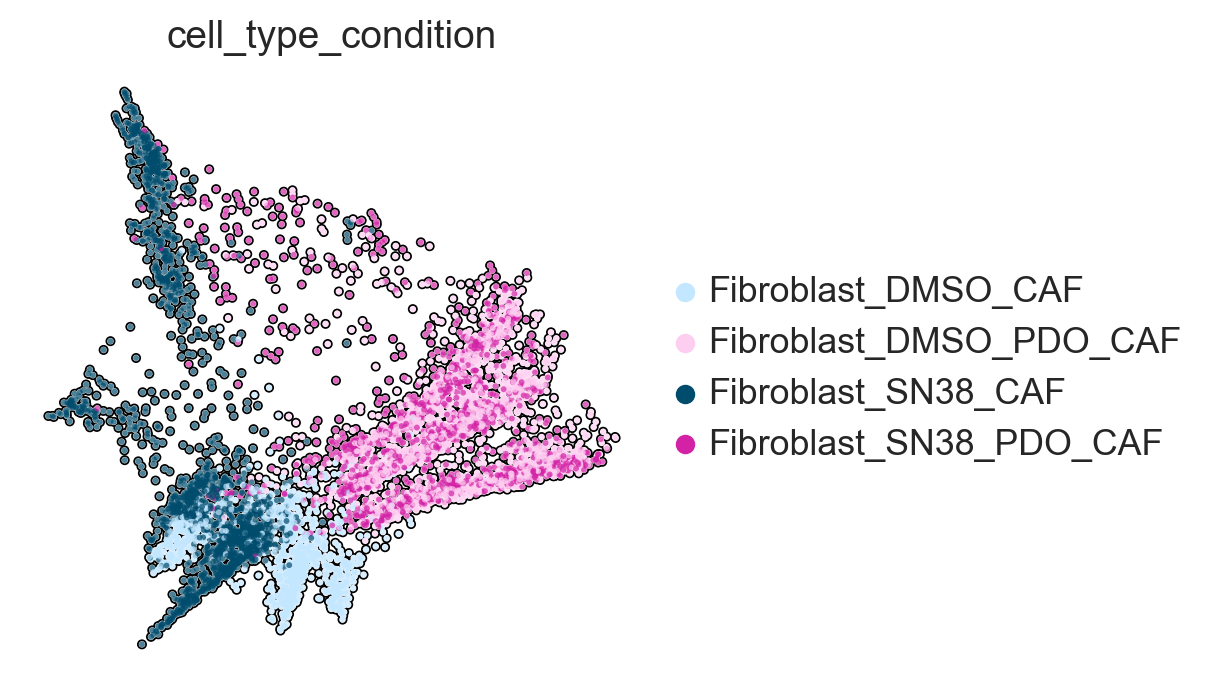

In [10]:
# PDO sample_ids
sc.external.pl.phate(caf_rna_adata, color=['cell_type_condition'],  
frameon=False, add_outline=True, palette=colour_dict_full, save="_caf_all_conds.pdf")

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

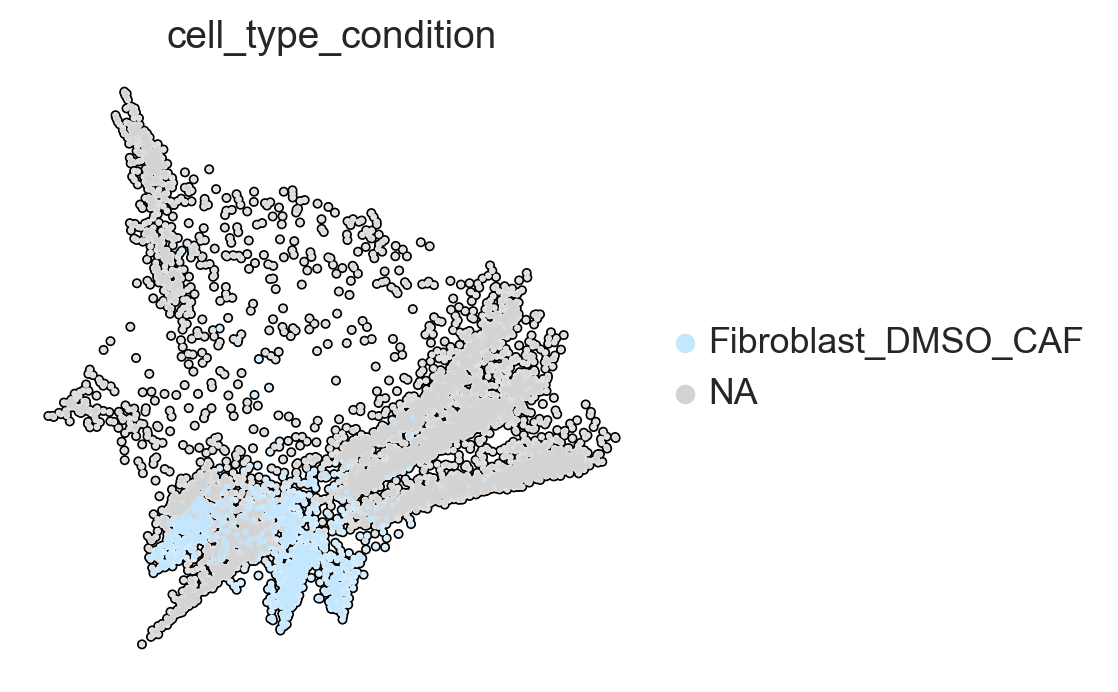

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

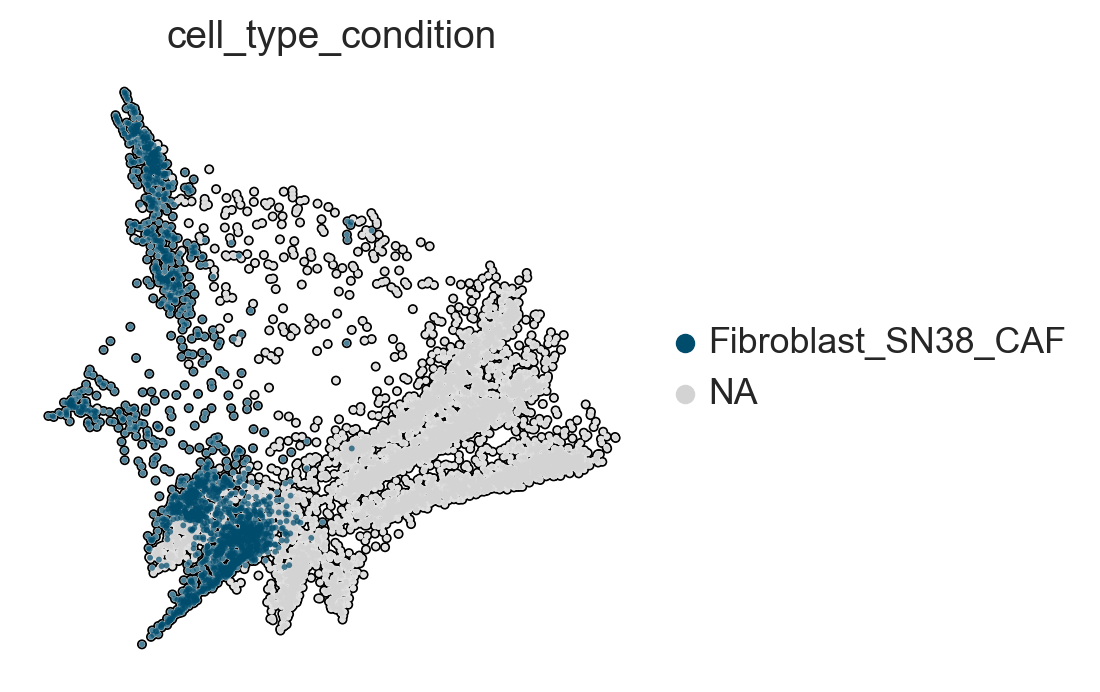

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

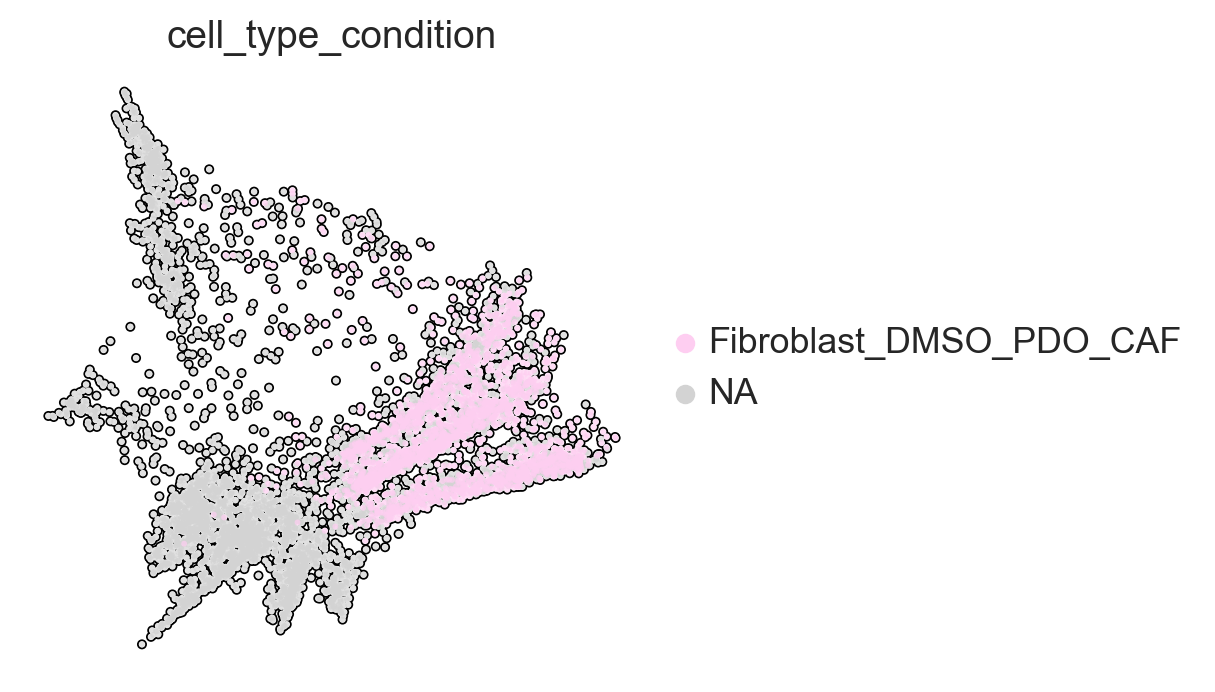

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be i

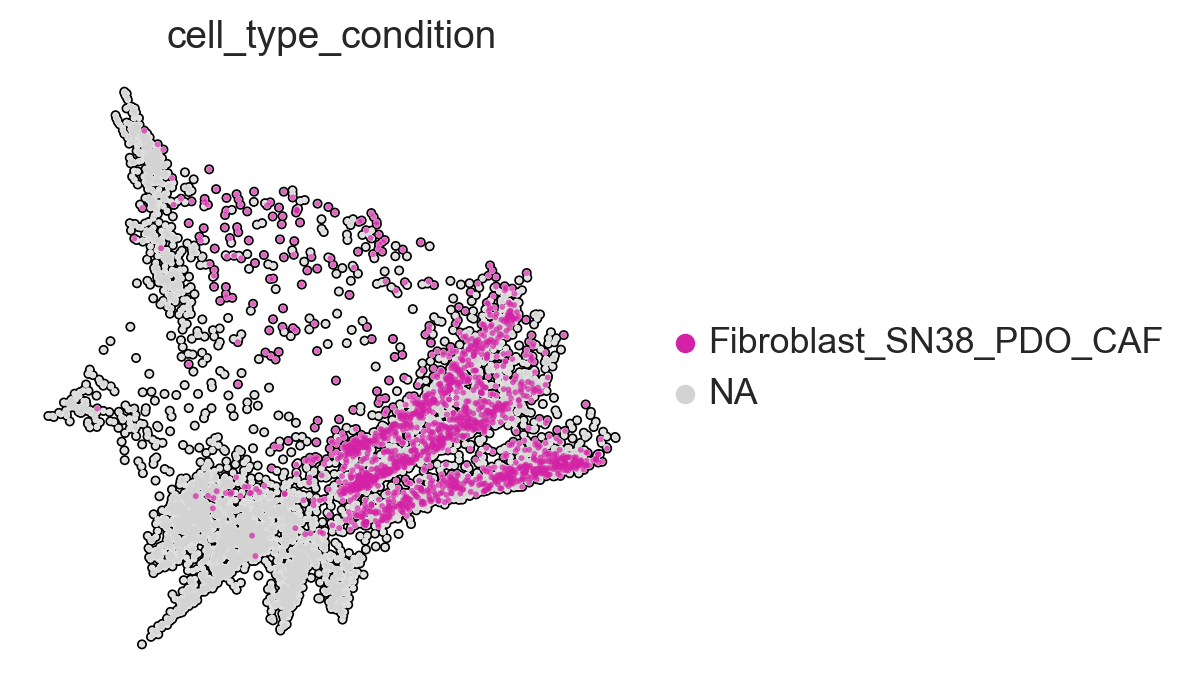

In [11]:
# View the condition RNA phate
sc.external.pl.phate(caf_rna_adata, groups='Fibroblast_DMSO_CAF', color=['cell_type_condition'],
frameon=False, add_outline=True, palette=colour_dict_full, save="_rna_dmso_mono")

sc.external.pl.phate(caf_rna_adata, groups='Fibroblast_SN38_CAF', color=['cell_type_condition'],
frameon=False, add_outline=True, palette=colour_dict_full, save="_rna_sn38_mono")

sc.external.pl.phate(caf_rna_adata, groups='Fibroblast_DMSO_PDO_CAF', color=['cell_type_condition'],
frameon=False, add_outline=True, palette=colour_dict_full, save="_rna_dmso_cc")

sc.external.pl.phate(caf_rna_adata, groups='Fibroblast_SN38_PDO_CAF', color=['cell_type_condition'],
frameon=False, add_outline=True, palette=colour_dict_full, save="_rna_sn38_cc")

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


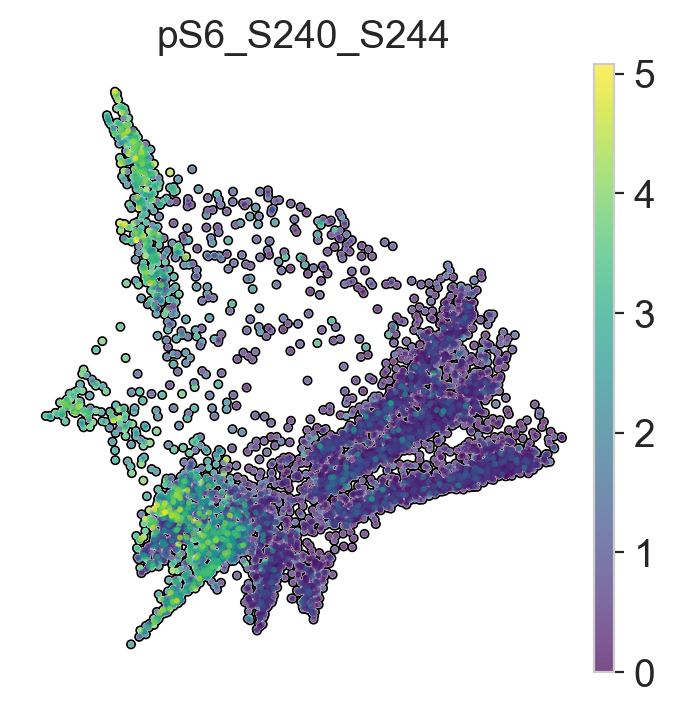

In [35]:
sc.pl.embedding(caf_adt_adata, basis='rna_phate', color=['pS6_S240_S244'], add_outline=True,
           ncols = 4, color_map='viridis', frameon=False,
           save = '_pS6_ptm')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


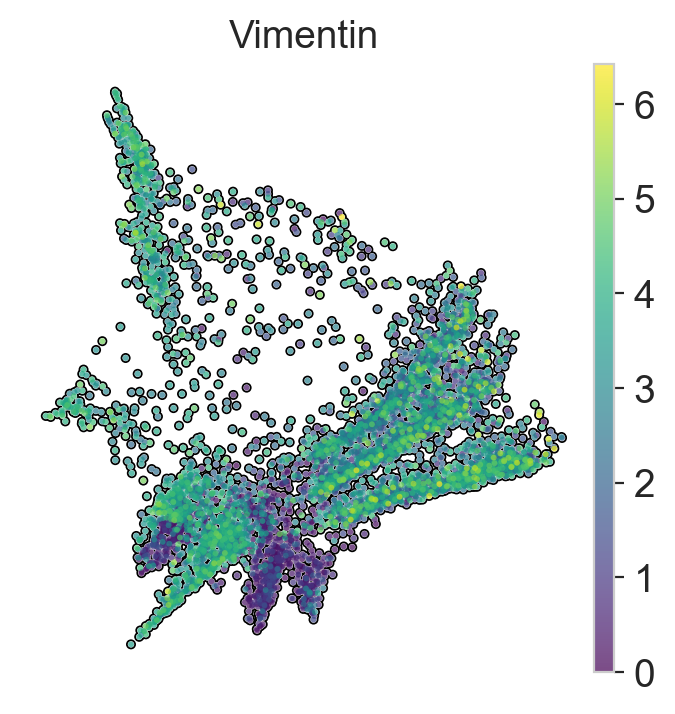

In [37]:
sc.pl.embedding(caf_adt_adata, basis='rna_phate', color=['Vimentin'], add_outline=True,
           ncols = 4, color_map='viridis', frameon=False,
           save = '_VIM_prot')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(


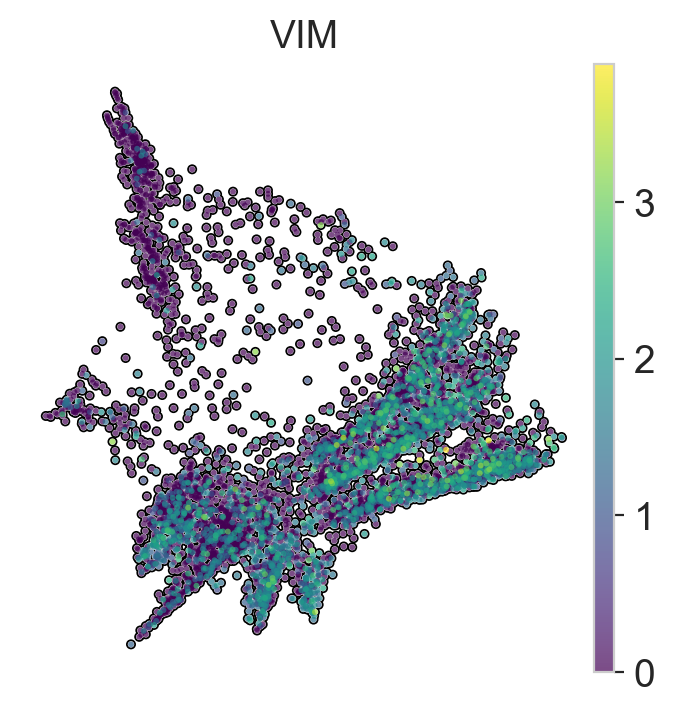

In [39]:
# View the condition RNA phate
sc.external.pl.phate(caf_rna_adata, color=['VIM'],
frameon=False, add_outline=True, color_map='viridis', save="_rna_VIM")

## CAF PTM responses

In [12]:
# Convert CAF adata to df
caf_adt_df = caf_adt_adata.to_df()

In [13]:
# Add cell_type_condition ID
caf_adt_df['cell_type_condition'] = caf_adt_adata.obs['cell_type_condition']

# Split into all four conditions
caf_dmso_mono_df = caf_adt_df[caf_adt_df['cell_type_condition'].isin(['Fibroblast_DMSO_CAF'])]
caf_sn38_mono_df = caf_adt_df[caf_adt_df['cell_type_condition'].isin(['Fibroblast_SN38_CAF'])]
caf_dmso_cc_df = caf_adt_df[caf_adt_df['cell_type_condition'].isin(['Fibroblast_DMSO_PDO_CAF'])]
caf_sn38_cc_df = caf_adt_df[caf_adt_df['cell_type_condition'].isin(['Fibroblast_SN38_PDO_CAF'])]  

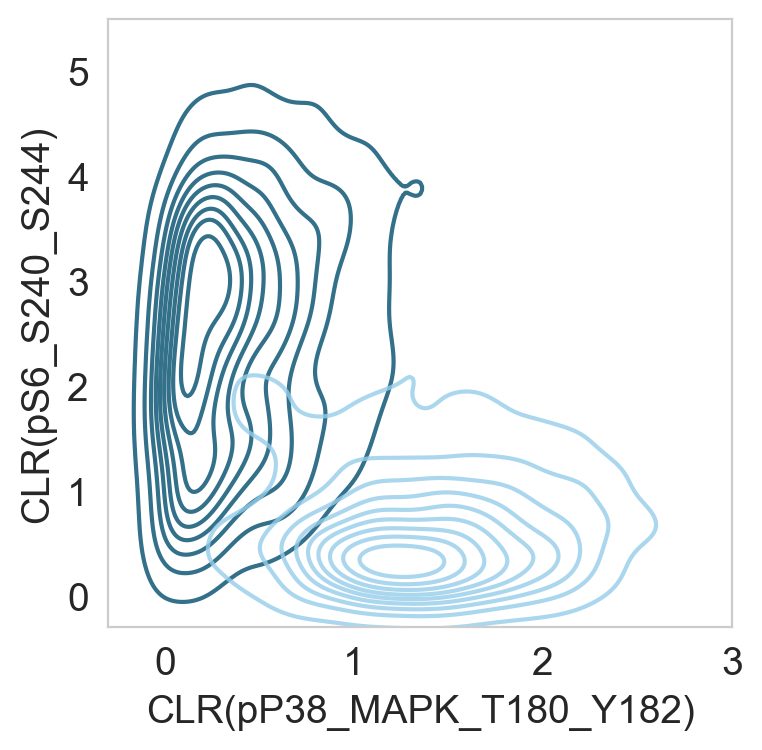

In [14]:
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Create a custom colormap
cmap_custom_dmso_caf_mono = mcolors.LinearSegmentedColormap.from_list("dmso_caf_mono", ["#F9FCFF", "#96CDEA"])
cmap_custom_SN38_caf_mono = mcolors.LinearSegmentedColormap.from_list("sn38_caf_mono", ["#E2ECF5", "#004c6d"])

 
sns.kdeplot(caf_sn38_mono_df, 
            x='pP38_MAPK_T180_Y182', y='pS6_S240_S244', 
            fill=False, label='CAF_mono_SN38', color="#004c6d",
            thresh=0.05, alpha=0.8, cbar=False)

# Monoculture
# Make two way kde plot
sns.kdeplot(caf_dmso_mono_df,
            x='pP38_MAPK_T180_Y182', y='pS6_S240_S244',
            fill=False, label='CAF_mono_DSMO', color= "#96CDEA",
            thresh=0.05, alpha=0.8, cbar=False)
 
plt.xlim((-0.3, 3))
plt.ylim((-0.3, 5.5))
plt.xlabel('CLR(pP38_MAPK_T180_Y182)')
plt.ylabel('CLR(pS6_S240_S244)')

plt.savefig('Fig_2/caf_analysis/KDE_plot_caf_mono_pS6vMAPK.pdf')

plt.show()


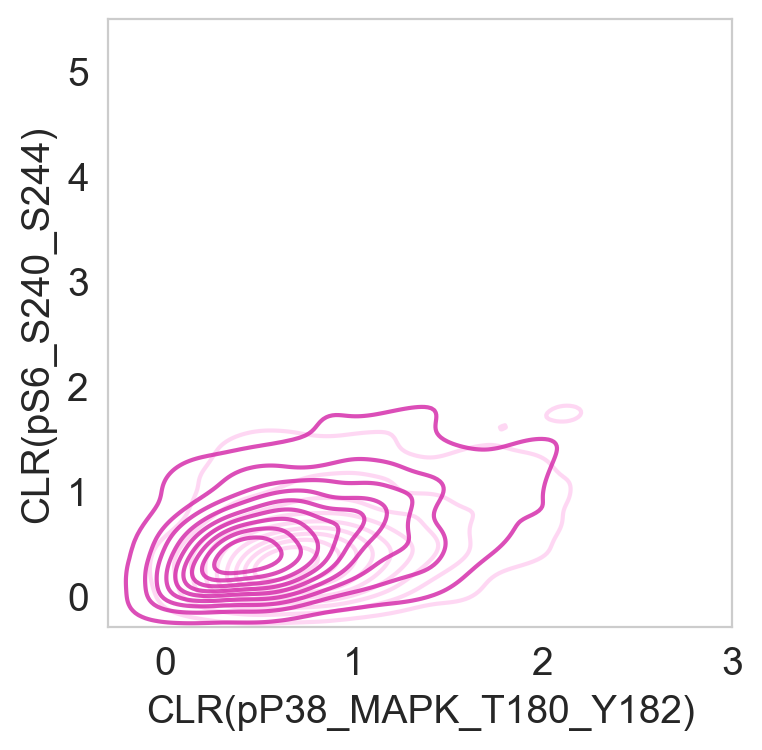

In [15]:
# Create a custom colormap
cmap_custom_dmso_caf_cc = mcolors.LinearSegmentedColormap.from_list("dmso_caf_cc", ["white", "#FECEF1"])
cmap_custom_SN38_caf_cc = mcolors.LinearSegmentedColormap.from_list("sn38_caf_cc", ["white", "#D322A6"])

# Monoculture
# Make two way kde plot
sns.kdeplot(caf_dmso_cc_df,
            x='pP38_MAPK_T180_Y182', y='pS6_S240_S244',
            fill=False, label='CAF_mono_DSMO', color= "#FECEF1",
            thresh=0.05, alpha=0.8, cbar=False)

sns.kdeplot(caf_sn38_cc_df, 
            x='pP38_MAPK_T180_Y182', y='pS6_S240_S244', 
            color="#D322A6", fill=False, label='CAF_mono_SN38',
            thresh=0.05, alpha=0.8, cbar=False)
 
plt.xlim((-0.3, 3))
plt.ylim((-0.3, 5.5))
plt.xlabel('CLR(pP38_MAPK_T180_Y182)')
plt.ylabel('CLR(pS6_S240_S244)')

plt.savefig('Fig_2/caf_analysis/KDE_plot_caf_cc_pS6vMAPK.pdf')

plt.show()


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed 

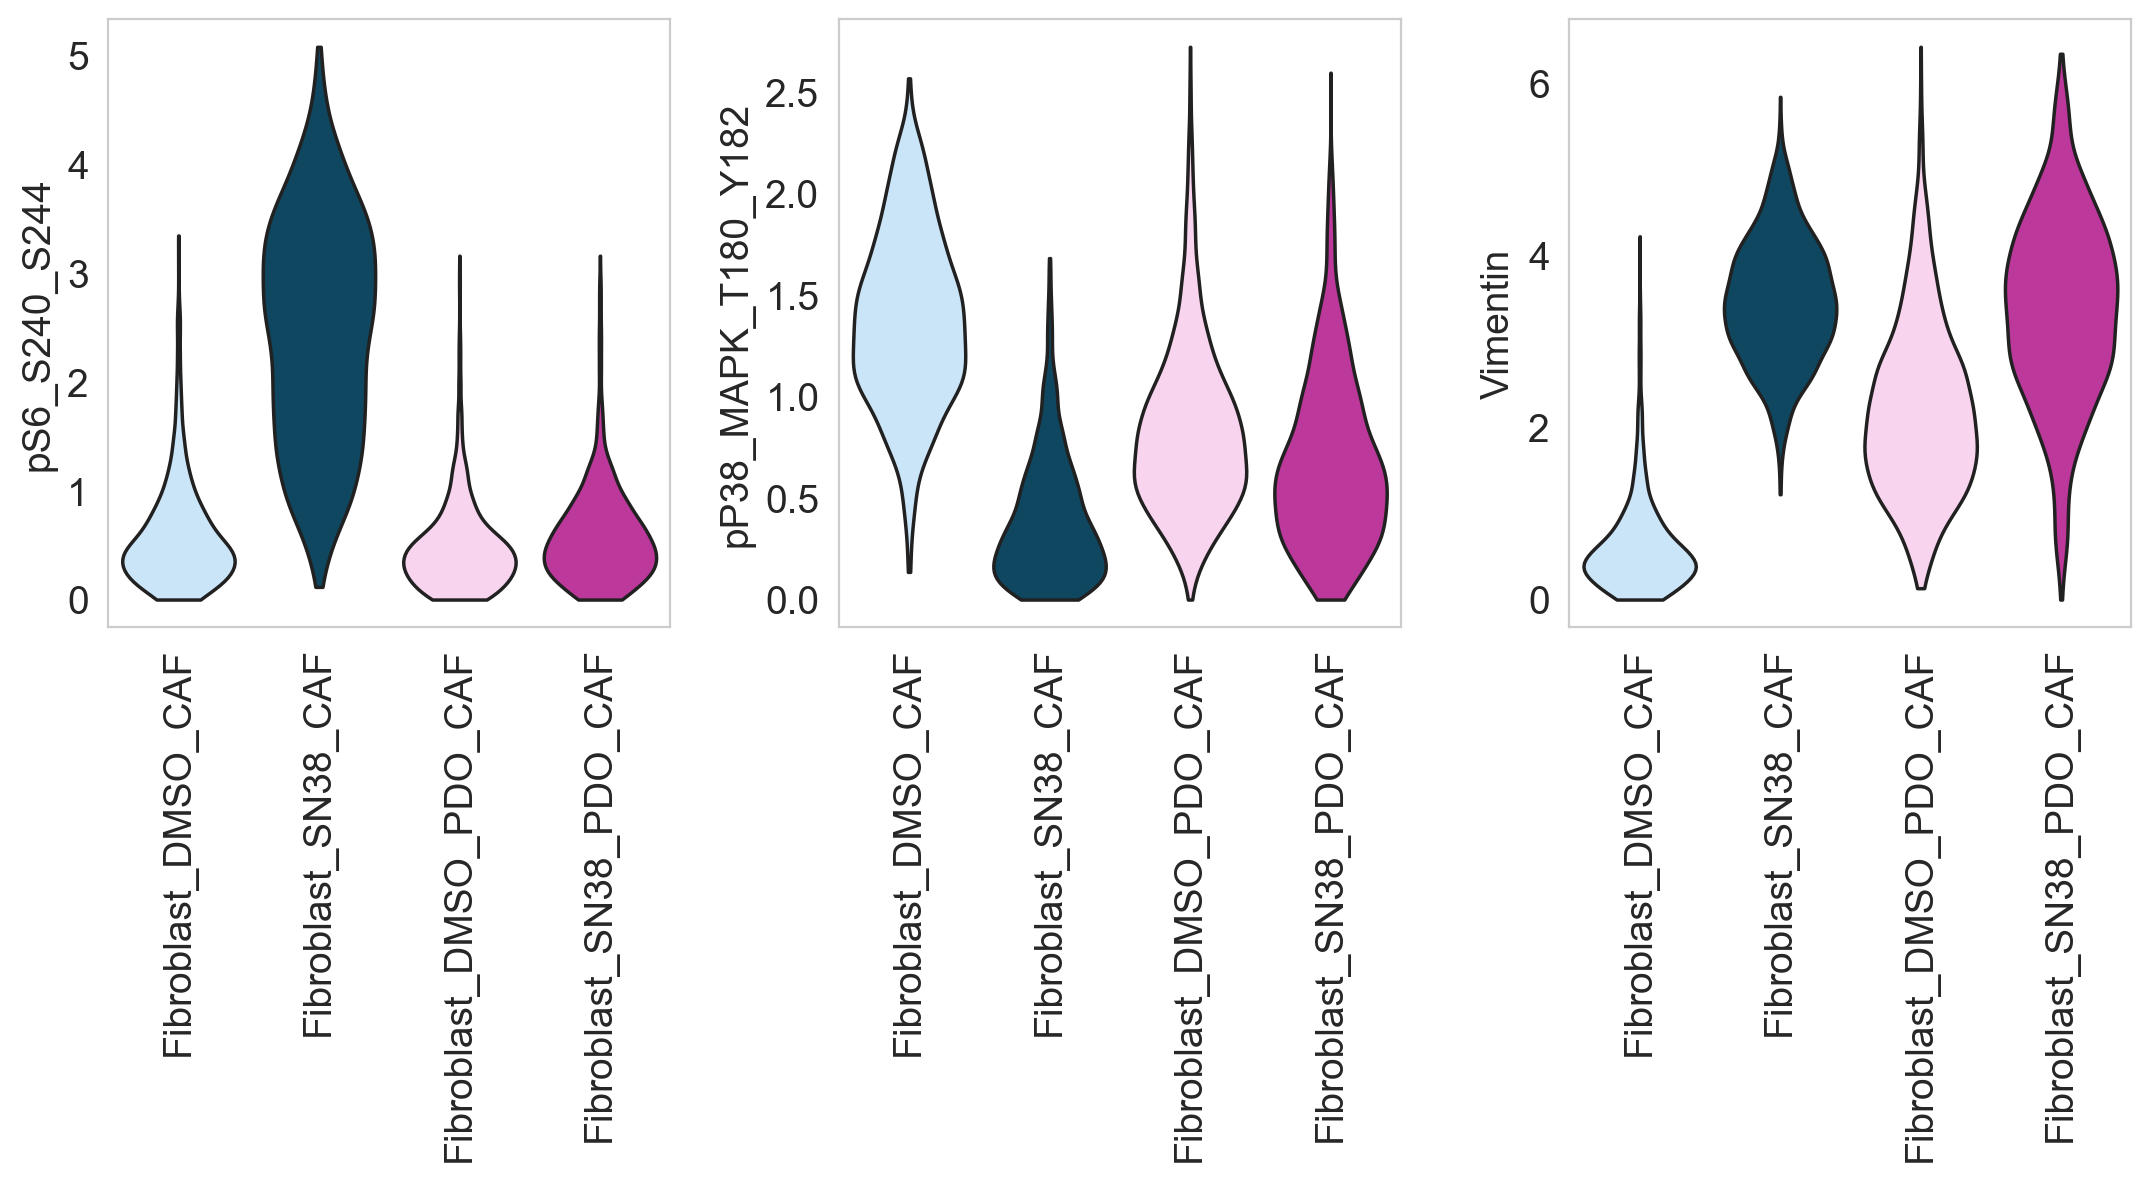

In [16]:
vl_order = ['Fibroblast_DMSO_CAF', 'Fibroblast_SN38_CAF', 'Fibroblast_DMSO_PDO_CAF', 'Fibroblast_SN38_PDO_CAF']
sc.pl.violin(caf_adt_adata, ['pS6_S240_S244', 'pP38_MAPK_T180_Y182', 'Vimentin'],
             stripplot=False, palette=colour_dict_full, groupby='cell_type_condition', log=False, rotation=90,
             order = vl_order, save="_pS6_caf")

## Gene-gene and Gene PTM correlations

In [18]:
# Gate cells in monoculture
mono_select = ['Fibroblast_DMSO_CAF', 'Fibroblast_SN38_CAF']
caf_rna_adata_mono = caf_rna_adata[caf_rna_adata.obs['cell_type_condition'].isin(mono_select)]
caf_adt_adata_mono = caf_adt_adata[caf_adt_adata.obs['cell_type_condition'].isin(mono_select)]

caf_rna_adata_mono.obs['cell_type_condition'].value_counts()

cell_type_condition
Fibroblast_SN38_CAF    1719
Fibroblast_DMSO_CAF    1081
Name: count, dtype: int64

In [19]:
# Extract the the dataframes
# ADT
caf_adt_mono_df =  caf_adt_adata_mono.to_df()

In [20]:
# Calculate DEGs
# Correct base error bug
caf_rna_adata_mono.uns['log1p']["base"] = None

# Add wilcox test for MELD derived drug response
sc.tl.rank_genes_groups(caf_rna_adata_mono, groupby='cell_type_condition', groups=['Fibroblast_DMSO_CAF', 'Fibroblast_SN38_CAF'], method='wilcoxon', key='sn38_mono_response')

ranking genes


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


In [22]:
# Extract all DEGs
group = 'Fibroblast_SN38_CAF' 

# Extracting the gene names, scores, log fold changes, and p-values
genes = caf_rna_adata_mono.uns['rank_genes_groups']['names'][group]
scores = caf_rna_adata_mono.uns['rank_genes_groups']['scores'][group]
logfoldchanges = caf_rna_adata_mono.uns['rank_genes_groups']['logfoldchanges'][group]
pvals = caf_rna_adata_mono.uns['rank_genes_groups']['pvals'][group]
pvals_adj = caf_rna_adata_mono.uns['rank_genes_groups']['pvals_adj'][group]

# Combining into a DataFrame
results_df = pd.DataFrame({
    'gene': genes,
    'score': scores,
    'logfoldchange': logfoldchanges,
    'pval': pvals,
    'pval_adj': pvals_adj
})

results_df.to_csv("caf_analysis/SN38_caf_mono.csv")

In [23]:
results_df

,gene,score,logfoldchange,pval,pval_adj
0,MALAT1,29.303263,1.206556,9.424642e-189,4.542677e-185
1,DNER,25.901327,2.800203,6.434492e-148,1.973634e-144
2,GPCPD1,23.779848,2.964916,5.398653e-125,1.138441e-121
3,KYNU,23.557056,1.921712,1.062831e-122,2.109407e-119
4,PDE10A,22.640244,3.655698,1.740781e-113,2.936698e-110
...,...,...,...,...,...
33735,ENSG00000280800,-32.702774,-1.661615,1.426180e-234,9.623863e-231
33736,ENSG00000281181,-32.799335,-1.504681,6.018265e-236,5.076407e-232
33737,AHNAK,-33.775421,-3.473180,4.528246e-250,5.092768e-246
33738,ENSG00000281383,-34.574547,-1.630844,6.097727e-262,1.028687e-257


In [24]:
# Filter by p-value and isolage gene names
deg_list = results_df[(results_df['pval_adj'] < 0.01) & ((results_df['logfoldchange'] > 0.5) | (results_df['logfoldchange'] < -0.5))]['gene'].tolist()

# check
len(deg_list)

2021

In [25]:
caf_mono_raw_adata = caf_rna_adata_mono.raw.to_adata()

# Filter the lnorm object on DEG
caf_mono_raw_adata_deg = caf_mono_raw_adata[:, deg_list]
caf_rna_mono_deg_df = caf_mono_raw_adata_deg.to_df()
caf_rna_mono_deg_df

Gene_Name,MALAT1,DNER,GPCPD1,KYNU,PDE10A,SGIP1,ATP2B1,ADARB1,FNDC3A,STC1,...,COL1A2,ENSG00000278996,SLC6A6,COL6A3,COL1A1,ENSG00000280800,ENSG00000281181,AHNAK,ENSG00000281383,ENSG00000280614
AAACATCGCTAAGGTCGTTACGTA_76,5.038842,0.000000,2.820187,3.250263,1.179972,0.000000,0.000000,1.179972,1.179972,1.706304,...,0.000000,4.087846,2.675919,1.179972,1.179972,4.629304,5.295197,0.000000,3.411335,2.304297
AAACATCGGATAGACACTATTTCA_76,5.651676,2.513716,0.000000,2.513716,0.000000,2.513716,3.165537,0.000000,0.000000,0.000000,...,0.000000,4.235619,0.000000,0.000000,0.000000,3.837363,4.387700,0.000000,0.000000,0.000000
AAACATCGGGAGAACAAGGCGGCA_76,5.123636,0.000000,0.000000,2.495654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.873253,5.156234,3.146706,3.933461,3.361214,5.332229,5.846495,2.495654,4.769510,4.901980
AACAACCAACACAGAAACTATATA_76,5.735710,1.371260,3.872138,3.808986,0.000000,1.371260,1.371260,2.284516,3.312833,1.928709,...,0.000000,4.614829,0.000000,0.000000,0.000000,3.312833,3.931537,0.000000,2.753760,0.000000
AACAACCAATTGGCTCACTATATA_76,4.710876,3.202887,3.202887,2.817541,0.000000,4.026686,2.182429,0.000000,3.480356,3.202887,...,0.000000,4.472165,0.000000,0.000000,0.000000,3.202887,3.875503,0.000000,0.000000,2.182429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCACGCACACCTTACCTATTTCA_79,6.016545,0.000000,0.000000,2.140949,0.000000,0.000000,0.000000,0.000000,2.140949,0.000000,...,0.000000,4.591047,0.000000,1.558935,1.558935,3.434955,4.331721,0.000000,3.306017,0.000000
TTCACGCACATACCAACTATTTCA_79,5.664792,0.000000,0.000000,4.166358,2.136325,3.152940,1.554798,4.106703,3.646528,0.000000,...,0.000000,4.464585,0.000000,0.000000,0.000000,3.544061,3.975520,0.000000,3.300968,1.554798
TTCACGCACCGAAGTATTGTCTTA_79,4.083634,1.263400,1.804158,0.000000,0.000000,2.616456,2.616456,2.153189,1.263400,0.000000,...,2.931833,5.903697,1.804158,1.804158,2.931833,5.280061,5.977115,0.000000,4.497696,4.525557
TTCACGCAGACTAGTAAGGCGGCA_79,4.441594,0.000000,0.000000,1.130678,0.000000,1.130678,0.000000,1.986951,1.130678,1.130678,...,1.647795,4.922562,1.647795,2.989704,3.181187,5.212240,5.855723,1.130678,5.024133,4.756831


In [26]:
# Compute correlation matrix for gene-gene
#caf_mono_corr_matrix_rna = caf_rna_mono_deg_df.corr()

# Export matrix
#caf_mono_corr_matrix_rna.to_csv('caf_analysis/caf_mono_deg_rna_matrix_corr.csv')
#caf_mono_corr_matrix_rna

In [28]:
# Read in .csv if not running corrleation
caf_mono_corr_matrix_rna = pd.read_csv('caf_analysis/caf_mono_deg_rna_matrix_corr.csv')
caf_mono_corr_matrix_rna

,Gene_Name,MALAT1,DNER,GPCPD1,KYNU,PDE10A,SGIP1,ATP2B1,ADARB1,FNDC3A,...,COL1A2,ENSG00000278996,SLC6A6,COL6A3,COL1A1,ENSG00000280800,ENSG00000281181,AHNAK,ENSG00000281383,ENSG00000280614
0,MALAT1,1.000000,0.122477,0.192451,0.222132,0.192647,0.110482,0.128736,0.168916,0.193638,...,-0.310637,-0.409621,-0.278780,-0.364943,-0.361392,-0.428615,-0.425974,-0.422776,-0.459052,-0.450532
1,DNER,0.122477,1.000000,0.366761,0.351633,0.380722,0.387951,0.419622,0.295591,0.315062,...,-0.255074,-0.210444,-0.336706,-0.238602,-0.347441,-0.273432,-0.290912,-0.304785,-0.282453,-0.341998
2,GPCPD1,0.192451,0.366761,1.000000,0.341137,0.407508,0.362186,0.325380,0.308453,0.287609,...,-0.206378,-0.251885,-0.272070,-0.179971,-0.299739,-0.282513,-0.284956,-0.310964,-0.290851,-0.316267
3,KYNU,0.222132,0.351633,0.341137,1.000000,0.324386,0.328872,0.312526,0.309766,0.224756,...,-0.149012,-0.255491,-0.185598,-0.123461,-0.232041,-0.251684,-0.270270,-0.312814,-0.245709,-0.310870
4,PDE10A,0.192647,0.380722,0.407508,0.324386,1.000000,0.385542,0.318768,0.321665,0.303272,...,-0.208208,-0.320234,-0.282673,-0.168657,-0.280057,-0.315224,-0.322545,-0.330334,-0.308884,-0.352893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,ENSG00000280800,-0.428615,-0.273432,-0.282513,-0.251684,-0.315224,-0.237126,-0.243849,-0.240481,-0.250961,...,0.352216,0.313260,0.366564,0.416988,0.481214,1.000000,0.809563,0.411611,0.713612,0.599298
2017,ENSG00000281181,-0.425974,-0.290912,-0.284956,-0.270270,-0.322545,-0.237113,-0.261080,-0.256042,-0.273684,...,0.364416,0.266086,0.354495,0.421518,0.516877,0.809563,1.000000,0.426871,0.709896,0.695781
2018,AHNAK,-0.422776,-0.304785,-0.310964,-0.312814,-0.330334,-0.237775,-0.292452,-0.261294,-0.281302,...,0.408315,0.399481,0.409541,0.408735,0.492289,0.411611,0.426871,1.000000,0.441025,0.494466
2019,ENSG00000281383,-0.459052,-0.282453,-0.290851,-0.245709,-0.308884,-0.226469,-0.233994,-0.209802,-0.242733,...,0.359925,0.430181,0.366084,0.401464,0.482571,0.713612,0.709896,0.441025,1.000000,0.598971


In [29]:
# Select subset of PTMs to correlate against genes
ptm_select = ['pHistone_H2A_X_S139', 'pNDRG1_T346', 'pS6_S240_S244', 'pP38_MAPK_T180_Y182', 'pP120_Catenin_T310', 'pRB_S807_811']

# subset 
caf_adt_mono_df_subset = caf_adt_mono_df[ptm_select]
caf_adt_mono_df_subset

feature_id,pHistone_H2A_X_S139,pNDRG1_T346,pS6_S240_S244,pP38_MAPK_T180_Y182,pP120_Catenin_T310,pRB_S807_811
barcode,,,,,,
AAACATCGCTAAGGTCGTTACGTA_76,0.814378,0.000000,2.857497,0.136174,0.430238,0.690820
AAACATCGGATAGACACTATTTCA_76,0.608958,1.320152,2.303716,0.589091,0.604793,0.444612
AAACATCGGGAGAACAAGGCGGCA_76,0.350133,0.000000,0.116398,1.204205,0.706247,0.780232
AACAACCAACACAGAAACTATATA_76,1.369860,0.863732,2.278746,1.112628,1.162954,1.053016
AACAACCAATTGGCTCACTATATA_76,0.608958,0.000000,1.599421,0.136174,0.294253,0.403914
...,...,...,...,...,...,...
TTCACGCACACCTTACCTATTTCA_79,1.369860,0.000000,3.139670,0.363007,0.461529,0.403914
TTCACGCACATACCAACTATTTCA_79,0.000000,1.117759,2.363542,0.136174,0.631137,0.444612
TTCACGCACCGAAGTATTGTCTTA_79,0.350133,0.522358,0.554262,1.088361,0.922321,0.962198


In [30]:
# Generate the corss ptm->gene correlation values
# Initialize an empty dataframe to store correlation values
correlation_matrix = pd.DataFrame(index=caf_adt_mono_df_subset.columns, columns=caf_rna_mono_deg_df.columns)

# Compute correlation for each ptm-gene pair
for ptm in caf_adt_mono_df_subset.columns:
    for gene in caf_rna_mono_deg_df.columns:
        correlation_matrix.loc[ptm, gene] = caf_adt_mono_df_subset[ptm].corr(caf_rna_mono_deg_df[gene])
        
correlation_matrix.to_csv('caf_analysis/adt_vs_rna_deg_caf_mono_matrix_corr.csv')
correlation_matrix

Gene_Name,MALAT1,DNER,GPCPD1,KYNU,PDE10A,SGIP1,ATP2B1,ADARB1,FNDC3A,STC1,...,COL1A2,ENSG00000278996,SLC6A6,COL6A3,COL1A1,ENSG00000280800,ENSG00000281181,AHNAK,ENSG00000281383,ENSG00000280614
feature_id,,,,,,,,,,,,,,,,,,,,,
pHistone_H2A_X_S139,0.234982,0.046507,0.040694,0.011652,-0.009702,-0.063128,0.022996,0.064334,0.070537,-0.068456,...,-0.186438,-0.112447,-0.184601,-0.267321,-0.216987,-0.056921,-0.091975,-0.180304,-0.104029,-0.118056
pNDRG1_T346,0.212397,0.007082,-0.000878,-0.002993,-0.005181,-0.091267,-0.017592,0.051796,0.061366,-0.105325,...,-0.151231,-0.042006,-0.123001,-0.181438,-0.137275,-0.082117,-0.094113,-0.151287,-0.087356,-0.092008
pS6_S240_S244,0.356502,0.382879,0.312709,0.22617,0.320355,0.170775,0.312293,0.278934,0.31921,0.316451,...,-0.350395,-0.307526,-0.449032,-0.405025,-0.421671,-0.299422,-0.321228,-0.501991,-0.346701,-0.40791
pP38_MAPK_T180_Y182,-0.401853,-0.433687,-0.398822,-0.361504,-0.42406,-0.334547,-0.351116,-0.305977,-0.326037,-0.395455,...,0.386414,0.335218,0.445722,0.419683,0.493216,0.495982,0.511273,0.557004,0.515961,0.641396
pP120_Catenin_T310,-0.253133,-0.255161,-0.268809,-0.250371,-0.312184,-0.281164,-0.203145,-0.166605,-0.166115,-0.312823,...,0.175249,0.249775,0.228774,0.173233,0.265438,0.367949,0.373754,0.321014,0.366354,0.440947
pRB_S807_811,-0.248267,-0.146243,-0.149693,-0.141366,-0.190351,-0.143733,-0.125355,-0.084519,-0.139237,-0.155105,...,0.210109,0.17521,0.225081,0.231466,0.280647,0.357909,0.359451,0.303902,0.374576,0.458388


## CAF TF regulon analysis

In [31]:
# Load the TF regulon network
net = dc.get_collectri(organism='human', split_complexes=False)
net

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [32]:
# Run ULM Enrichment Analysis
dc.run_ulm(
    mat=caf_rna_adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

414 features of mat are empty, they will be removed.
Running ulm on mat with 6698 samples and 33326 targets for 730 sources.


100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


In [33]:
caf_rna_adata.obsm['ulm_estimate']
acts = dc.get_acts(caf_rna_adata, obsm_key='ulm_estimate')

df = dc.rank_sources_groups(acts, groupby='cell_type_condition', reference='Fibroblast_DMSO_CAF', method='t-test_overestim_var')

df.to_csv('caf_analysis/caf_mono_deregulated_TFs.csv')

df_mono = dc.rank_sources_groups(acts, groupby='cell_type_condition', reference='Fibroblast_DMSO_PDO_CAF', method='t-test_overestim_var')
df_mono.to_csv('caf_analysis/caf_cc_deregulated_TFs.csv')

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


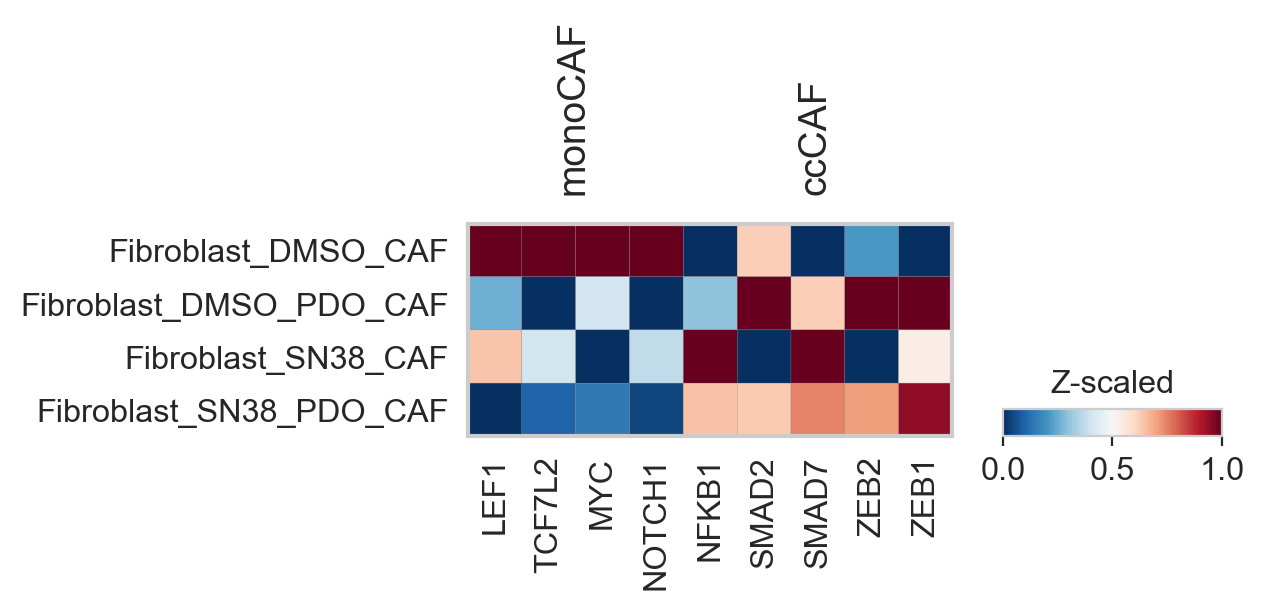

In [34]:
markers = {
    'monoCAF': ['LEF1', 'TCF7L2', 'MYC', 'NOTCH1'],
    'ccCAF': ['NFKB1', 'SMAD2', 'SMAD7', 'ZEB2', 'ZEB1']
}

sc.pl.matrixplot(acts, markers, 'cell_type_condition', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled', cmap='RdBu_r', save='CAF_TF_regulon_activity.png')